In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

# Data provided 

1. Update Date and Time (ISO)
2. Update Duration (ms)
3. Reading Date and Time (ISO)
4. Air pressure (mb)
5. Air temperature (C) – A variable of interest.
6. Tide height (m) – Another variable of interest.
7. Wind direction (deg)
8. Wind gust speed (kn)
9. Wind speed (kn)
10. True air temperature (C) – Ground truth air temperature, against which you should compare your predictions.
11. True tide height (m) – Ground truth tide height, against which you should compare your predictions.
12. Independent tide height prediction (m) – These are some GP predictions prepared earlier for you to compare against, if you so choose.
13. Independent tide height deviation (m) – The standard deviation of the GP predictions above.
14. Dependent tide height prediction (m) – Another GP prediction built using three additional sensors not provided to you.
15. Dependent tide height deviation (m) – The standard deviation of the GP predictions above.
16. Independent air temperature prediction (C) – These are some GP predictions prepared earlier for you to compare against, if you so choose.
17. Independent air temperature deviation (C) – The standard deviation of the GP predictions above.
18. Dependent air temperature prediction (C) – Another GP prediction built using three additional sensors not provided to you.
19. Dependent air temperature deviation (C) – The standard deviation of the GP predictions above.

In [45]:
weather_data = pd.read_csv('sotonmet.txt')
cols = weather_data.columns

# Convert date strings to datetime objects
date_conversion = lambda date_string: datetime.datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S')
weather_data[cols[0]] = weather_data[cols[0]].apply(date_conversion)
weather_data[cols[2]] = weather_data[cols[2]].apply(date_conversion)

# Extracting missing data separately
missing_rows = weather_data.isnull().any(axis=1)
missing_data = weather_data[missing_rows]
missing_reading_times = missing_data[cols[2]].values
missing_tide_heights = missing_data[cols[10]].values

# Extracting all ground truth data
all_reading_times = weather_data[cols[2]].values
true_tide_heights = weather_data[cols[10]].values
true_temperatures = weather_data[cols[11]].values
weather_data.dropna(inplace=True)

# Training data
reading_times = weather_data[cols[2]]
tide_heights = weather_data[cols[5]]

In [22]:
def column_plotter(ax, column_indices, color="tab:red"):
    """Plot select columns from Dataframe"""
    for i, col_no in enumerate(column_indices):
        ax[i].scatter(reading_times, weather_data[cols[col_no]], marker="x", s=5, color=color)
        ax[i].set_ylabel(cols[col_no])
    plt.tight_layout()

# Variables for prediction

<IPython.core.display.Javascript object>


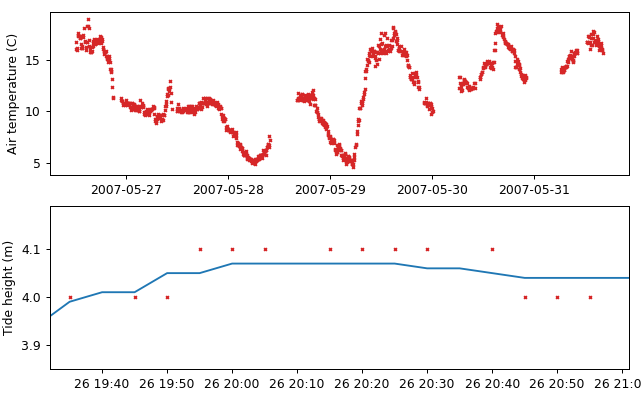

In [28]:
target_cols = [4, 5]
fig, ax = plt.subplots(len(target_cols), 1, figsize=(8,5))
column_plotter(ax, target_cols)
ax[1].plot(all_reading_times, true_tide_heights)
plt.show()

Remarks
- Clear periodic trend in tide (~12.5hr period)
- Amplitude varies fairly smoothly over about a day
- Distinct bumps at high tide and low-mid tide

# Other potentially useful inputs

<IPython.core.display.Javascript object>


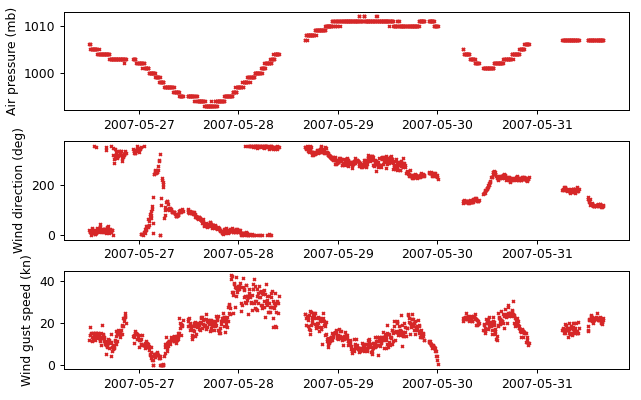

In [31]:
cols_of_interest = [3, 6, 7]
fig, ax = plt.subplots(len(cols_of_interest), 1, figsize=(8, 5))
column_plotter(ax,cols_of_interest)
plt.show()

# Fitting Gaussian Process model

In [10]:
from gps import GaussianProcess
from kernels import IsoSQEKernel, PeriodicKernel, Matern12Kernel, Matern32Kernel, QuadraticKernel
import torch

Pre-processing input data

In [51]:
minute_constant = 60e9  # Scale readings to minutes (sensible length-scale)
start_time = weather_data[cols[2]].values[0]
scaled_reading_times = torch.tensor((weather_data[cols[2]].values - start_time).astype(float)/minute_constant, dtype=torch.float64)
scaled_all_reading_times = torch.tensor((all_reading_times - start_time).astype(float)/minute_constant, dtype=torch.float64)
scaled_missing_times = torch.tensor((missing_reading_times - start_time).astype(float)/minute_constant, dtype=torch.float64)

@np.vectorize
def itt(scaled_time_reading):
    """Inverse time transform (ITT)
    Convert scaled time readings to original np datetime."""
    elapsed_ns = np.timedelta64(int(scaled_time_reading*minute_constant), "ns") 
    return start_time + elapsed_ns

quantisation_variance = 0.02886 # Variance of uniform noise due to quantisation of tide height 0.1^2/12
sigma_n = quantisation_variance**0.5
data_noise = quantisation_variance*torch.randn(len(raw_tide_heights))  # Approximate w/ Gaussian
tide_heights = torch.tensor(weather_data[cols[5]].values, dtype=torch.float64) + data_noise

tide_std, tide_mean = torch.std_mean(tide_heights)
scaled_tide_heights = (tide_heights-tide_mean)/tide_std
scaled_true_heights = (true_tide_heights-tide_mean.numpy())/tide_std.numpy()  # Scale ground truth for ref. plotting

@np.vectorize
def iht(scaled_tide_reading):
    """Inverse height transform (IHT)
    Convert scaled tide heights back to raw value in metres"""
    return scaled_tide_reading * tide_std + tide_mean

In [74]:
def compute_gp_performance(gp, jitter=0):
    """Compute performance metrics of a given GP on the data set"""
    
    # Get predictive distribution over all test points and just at missing entries
    test_means, test_vars = gp.compute_predictive_means_vars(scaled_all_reading_times, jitter=jitter)
    missing_means, missing_vars = gp.compute_predictive_means_vars(scaled_missing_times, jitter=jitter)
    
    # Un-normalise uncertainty back to metres
    test_covariance = (tide_std**2)*test_vars
    missing_covariance = (tide_std**2)*missing_vars
    
    # Compute NLL for all test points and missing points
    test_nll = gp.gaussian_nll(torch.tensor(true_tide_heights), torch.tensor(iht(test_means)), 
                               test_covariance, jitter=jitter)/len(missing_tide_heights)
    missing_nll = gp.gaussian_nll(torch.tensor(missing_tide_heights), torch.tensor(iht(missing_means)), 
                               missing_covariance, jitter=jitter)/len(missing_tide_heights)
    
    # Computing RMSE in metres
    test_rmse = np.mean((true_tide_heights-iht(test_means))**2)**0.5
    missing_rmse = np.mean((missing_tide_heights-iht(missing_means))**2)**0.5
    
    print(f"Marginal LL : {-gp.compute_marginal_nll()}")
    print(f"All test data LL : {-test_nll}")
    print(f"Missing data LL : {-missing_nll}")
    print(f"All test data rmse : {test_rmse}")
    print(f"Missing data rmse : {missing_rmse}")
    
    return


def gp_inference(covar_kernel, epochs=250, sigma_n=0.1, jitter=0, lr=1e-3):
    gp = GaussianProcess(covar_kernel=covar_kernel, sigma_n=sigma_n, training_data=scaled_reading_times, 
                          labels=scaled_tide_heights, learn_noise=False)
    
    print("Prior to optimisation:\n")
    compute_gp_performance(gp, jitter=jitter)

    # Maximising marginal likelihood w.r.t hyper-parameters
    gp.optimise_hyperparams(epochs, lr=lr)
    
    # Sample GP in range +/-40% of data
    sample_times = torch.linspace(-0.4*torch.max(scaled_reading_times), 1.4*torch.max(scaled_reading_times), 1000)
    sample_means, sample_vars = gp.compute_predictive_means_vars(sample_times, jitter=jitter)
    sigma_vector = np.diag(sample_vars)**0.5  # Diagonal covariance for uncertainty plots.
    transformed_times = itt(sample_times)  # Sample times converted back to timestamps
    
    print("After optimisation:\n")
    compute_gp_performance(gp, jitter=jitter)
    
    plt.figure(figsize=(8,5))
    # Plot results back in original units, inverting normalisations applied.
    plt.plot(transformed_times, iht(sample_means), color="tab:blue", label="GP mean")

    for i in range(3):
        function_draw = np.random.multivariate_normal(sample_means, sample_vars)
        if i == 0:
            plt.plot(transformed_times, iht(function_draw), "--", lw=0.5, color="red", label=f"Function draws")
        else:
            plt.plot(transformed_times, iht(function_draw), "--", lw=0.5, color="red")
            
    
    plt.scatter(reading_times, tide_heights, s=10, marker="x", label="Training data", color="black")

    alphas = [0.5, 0.3, 0.1]
    for i in range(3):
        plt.fill_between(transformed_times, iht(sample_means-(i+1)*sigma_vector), iht(sample_means+(i+1)*sigma_vector),
                        alpha=alphas[i], color="gray", label=fr"GP Uncertainty - ${i+1}\sigma$")
        
    plt.ylabel("Tide height / m", fontsize=14)
    plt.xlabel("Timestamp / days", fontsize=14)
    bottom, top = plt.ylim()
    plt.ylim(bottom=bottom-2)  # Add extra space for legend
    plt.xticks(rotation=45, fontsize=8)
    plt.yticks(fontsize=8)
    plt.plot(all_reading_times, true_tide_heights, label="Ground truth", color="green")
    plt.legend(fontsize=11, ncol=2)
    plt.tight_layout()
    plt.show()
    
    return gp

# Fitting exponentiated quadratic GP

Prior to optimisation:

Marginal LL : tensor([[1273.1496]], dtype=torch.float64, grad_fn=<NegBackward>)
All test data LL : tensor([[14.7675]], dtype=torch.float64)
Missing data LL : tensor([[3.4009]], dtype=torch.float64)
All test data rmse : 0.15501721524945172
Missing data rmse : 0.29657217069644
Old hyper-parameters: tensor([74.5000,  2.0000], dtype=torch.float64, grad_fn=<ExpBackward>)


  0%|          | 0/50 [00:00<?, ?it/s]

Negative marginal likelihood : tensor([[-1273.1496]], dtype=torch.float64, grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


New hyper-parameters: tensor([78.2835,  1.9034], dtype=torch.float64, grad_fn=<ExpBackward>)
Negative log-likelihood : tensor([[-1288.1622]], dtype=torch.float64, grad_fn=<MulBackward0>)
After optimisation:

Marginal LL : tensor([[1288.4517]], dtype=torch.float64, grad_fn=<NegBackward>)
All test data LL : tensor([[14.7762]], dtype=torch.float64)
Missing data LL : tensor([[3.4105]], dtype=torch.float64)
All test data rmse : 0.1509310258223903
Missing data rmse : 0.28867070453823496


<ipython-input-70-0f9adbbe6f13>:55: RuntimeWarning: covariance is not positive-semidefinite.
  function_draw = np.random.multivariate_normal(sample_means, sample_vars)
<ipython-input-70-0f9adbbe6f13>:55: RuntimeWarning: covariance is not positive-semidefinite.
  function_draw = np.random.multivariate_normal(sample_means, sample_vars)
<ipython-input-70-0f9adbbe6f13>:55: RuntimeWarning: covariance is not positive-semidefinite.
  function_draw = np.random.multivariate_normal(sample_means, sample_vars)


<IPython.core.display.Javascript object>


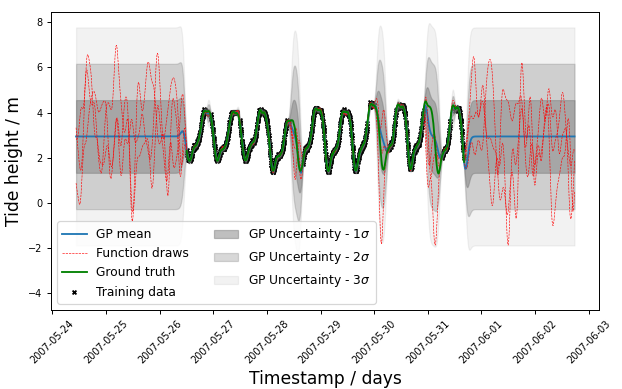

In [73]:
period = 60*12 + 25  # Exact tidal period about 12h and 25 mins

iso_params = torch.tensor(np.log([period/10, 2]), requires_grad=True)

iso = IsoSQEKernel(iso_params)

gp_inference(iso, 50, sigma_n=sigma_n, lr=1e-3, jitter=1e-2)

# Fitting periodic GP model

Prior to optimisation:

Marginal LL : tensor([[121.7580]], dtype=torch.float64, grad_fn=<NegBackward>)
All test data LL : tensor([[-898.9358]], dtype=torch.float64)
Missing data LL : tensor([[-311.9578]], dtype=torch.float64)
All test data rmse : 0.25150753892574335
Missing data rmse : 0.2878980801108331
Old hyper-parameters: tensor([ 10.0000,   2.0000, 745.0000], dtype=torch.float64,
       grad_fn=<ExpBackward>)


  0%|          | 0/50 [00:00<?, ?it/s]

Negative marginal likelihood : tensor([[-121.7580]], dtype=torch.float64, grad_fn=<MulBackward0>)


100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


New hyper-parameters: tensor([  9.5166,   2.1015, 742.5480], dtype=torch.float64,
       grad_fn=<ExpBackward>)
Negative log-likelihood : tensor([[-228.2782]], dtype=torch.float64, grad_fn=<MulBackward0>)
After optimisation:

Marginal LL : tensor([[229.3888]], dtype=torch.float64, grad_fn=<NegBackward>)
All test data LL : tensor([[-755.1033]], dtype=torch.float64)
Missing data LL : tensor([[-266.6620]], dtype=torch.float64)
All test data rmse : 0.23923314793309006
Missing data rmse : 0.26906007325368386


<ipython-input-62-b4015e468fef>:55: RuntimeWarning: covariance is not positive-semidefinite.
  function_draw = np.random.multivariate_normal(sample_means, sample_vars)
<ipython-input-62-b4015e468fef>:55: RuntimeWarning: covariance is not positive-semidefinite.
  function_draw = np.random.multivariate_normal(sample_means, sample_vars)
<ipython-input-62-b4015e468fef>:55: RuntimeWarning: covariance is not positive-semidefinite.
  function_draw = np.random.multivariate_normal(sample_means, sample_vars)


<IPython.core.display.Javascript object>


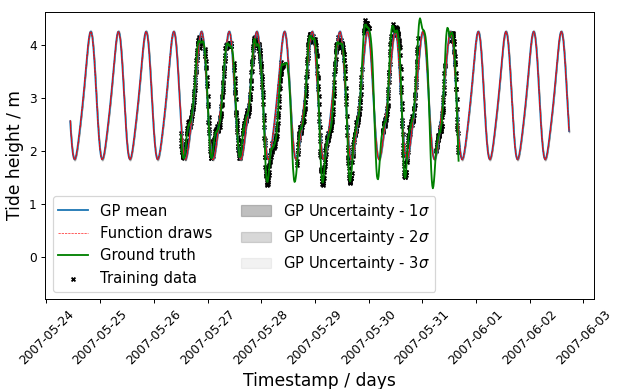

In [65]:
period = 60*12 + 25  # Exact tidal period about 12h and 25 mins (deliberately over-estimating)

periodic_params = torch.tensor(np.log([10, 2, period]), requires_grad=True)
periodic = PeriodicKernel(periodic_params)

gp_inference(periodic, 50, sigma_n=sigma_n, lr=1e-3, jitter=1e-2)

# Fitting composite GP model (periodic + periodic * RQ covariance)

Prior to optimisation:

Marginal LL : tensor([[1403.8072]], dtype=torch.float64, grad_fn=<NegBackward>)
All test data LL : tensor([[14.8393]], dtype=torch.float64)
Missing data LL : tensor([[3.4839]], dtype=torch.float64)
All test data rmse : 0.04374484070742695
Missing data rmse : 0.07890387223627023
Old hyper-parameters: tensor([372.5000,   0.5000,   1.0000], dtype=torch.float64,
       grad_fn=<ExpBackward>)tensor([5.0000e-01, 5.0000e-01, 7.4500e+02], dtype=torch.float64,
       grad_fn=<ExpBackward>)tensor([5.0000e-01, 5.0000e-01, 7.4500e+02], dtype=torch.float64,
       grad_fn=<ExpBackward>)


0it [00:00, ?it/s]

Negative marginal likelihood : tensor([[-1403.8072]], dtype=torch.float64, grad_fn=<MulBackward0>)
New hyper-parameters: tensor([372.5000,   0.5000,   1.0000], dtype=torch.float64,
       grad_fn=<ExpBackward>)tensor([5.0000e-01, 5.0000e-01, 7.4500e+02], dtype=torch.float64,
       grad_fn=<ExpBackward>)tensor([5.0000e-01, 5.0000e-01, 7.4500e+02], dtype=torch.float64,
       grad_fn=<ExpBackward>)
Negative log-likelihood : tensor([[-1403.8072]], dtype=torch.float64, grad_fn=<MulBackward0>)


After optimisation:

Marginal LL : tensor([[1403.8072]], dtype=torch.float64, grad_fn=<NegBackward>)
All test data LL : tensor([[14.8393]], dtype=torch.float64)
Missing data LL : tensor([[3.4839]], dtype=torch.float64)
All test data rmse : 0.04374484070742695
Missing data rmse : 0.07890387223627023


<ipython-input-74-ce39a49e162a>:55: RuntimeWarning: covariance is not positive-semidefinite.
  function_draw = np.random.multivariate_normal(sample_means, sample_vars)
<ipython-input-74-ce39a49e162a>:55: RuntimeWarning: covariance is not positive-semidefinite.
  function_draw = np.random.multivariate_normal(sample_means, sample_vars)
<ipython-input-74-ce39a49e162a>:55: RuntimeWarning: covariance is not positive-semidefinite.
  function_draw = np.random.multivariate_normal(sample_means, sample_vars)


<IPython.core.display.Javascript object>


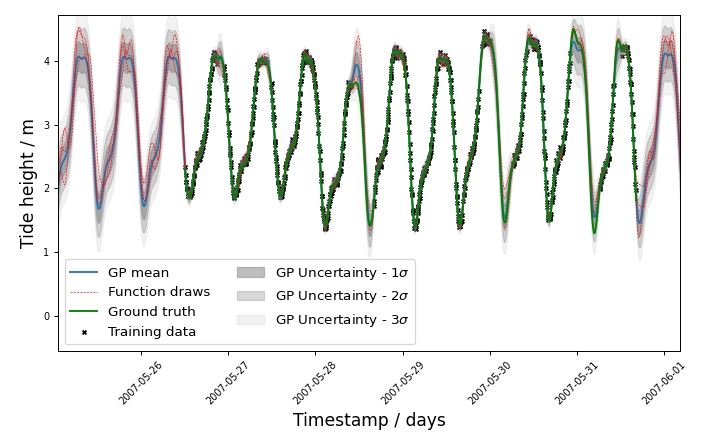

In [75]:
period = 12*60 + 25

periodic_params = torch.tensor(np.log([0.5, 0.5, period]), requires_grad=True)
periodic = PeriodicKernel(periodic_params)

quadratic_params = torch.tensor(np.log([period/2, .5, 1]), requires_grad=True)
rq_kernel = QuadraticKernel(quadratic_params, 2)

combined_kernel = rq_kernel*periodic + periodic

optimised_gp = gp_inference(combined_kernel, 0, sigma_n=sigma_n, jitter=1e-2, lr=1e-3)

# Lookahead inference using GPs

In [473]:
from gps import LookaheadGP

In [474]:
optimised_kernel = optimised_gp.covar_kernel

<ipython-input-476-e5f8d2acf431>:23: RuntimeWarning: covariance is not positive-semidefinite.
  function_draw = np.random.multivariate_normal(causal_means, causal_vars)


<IPython.core.display.Javascript object>


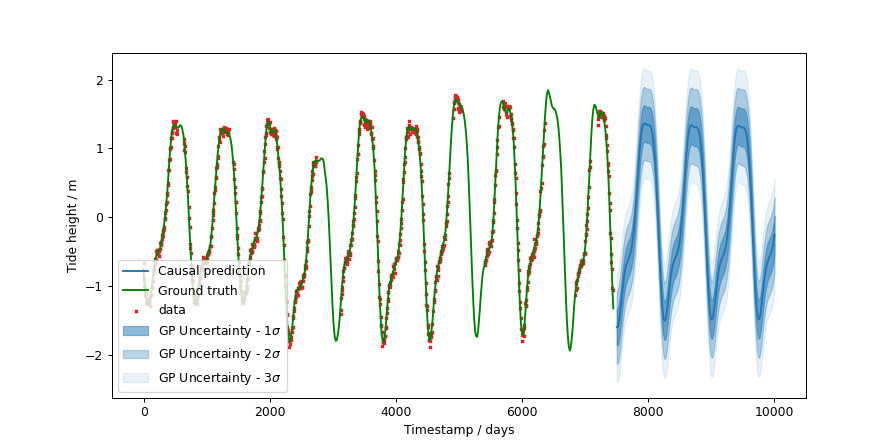

In [476]:
causalgp = LookaheadGP(covar_kernel=optimised_kernel, sigma_n=0.5, training_data=scaled_reading_times, 
                          labels=scaled_tide_heights, learn_noise=False)

t_predictions = torch.linspace(7500, 10000, 1000)

causal_means, causal_vars = causalgp.compute_lookahead_predictive_means_vars(t_predictions)

plt.figure(figsize=(10,5))
plt.scatter(scaled_reading_times, scaled_tide_heights, s=5, marker="x", label="data", color="tab:red")
#plt.plot(sample_times, sample_means, color="tab:blue", label="GP mean"

plt.plot(t_predictions, causal_means, label="Causal prediction")
sigma_vector = np.diag(causal_vars)**0.5

alphas = [0.5, 0.3, 0.1]
for i in range(3):
    j = i + 1
    plt.fill_between(t_predictions, causal_means-j*sigma_vector, causal_means+j*sigma_vector,
                    alpha=alphas[i], color="tab:blue", label=fr"GP Uncertainty - ${i+1}\sigma$")


for i in range(3):
    function_draw = np.random.multivariate_normal(causal_means, causal_vars)
    #plt.plot(sample_times, function_draw, label=f"Function draw {i+1}")


plt.ylabel("Tide height / m")
plt.xlabel("Timestamp / days")
plt.plot(scaled_all_reading_times, scaled_true_heights, label="Ground truth", color="green")
plt.legend()
plt.show()